In [199]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from xgboost import XGBRegressor

In [268]:
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

train_path  = "regression-dataset-train.csv"
test_path = "regression-dataset-test-unlabeled.csv"
df_train, df_test = load_data(train_path, test_path)

df_train = df_train.drop(['id'], axis =1)


df_train.head()

date  season_id  year  month  is_holiday  weekday  is_workingday  \
0  31-07-2019          3     1      7           0        2              1   
1  03-03-2019          1     1      3           0        6              0   
2  30-12-2019          1     1     12           0        0              0   
3  28-04-2019          2     1      4           0        6              0   
4  22-04-2018          2     0      4           0        5              1   

   weather_condition  temperature  feels_like_temp  humidity  wind_speed  \
0                  1    29.246653          33.1448   70.4167   11.083475   
1                  2    16.980847          20.6746   62.1250   10.792293   
2                  1    10.489153          11.5850   48.3333   23.500518   
3                  2    15.443347          18.8752   48.9583    8.708325   
4                  2    13.803347          16.0977   72.9583   14.707907   

   total_users  
0         7216  
1         4066  
2         1796  
3         4220  
4         1683

In [269]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               510 non-null    object 
 1   season_id          510 non-null    int64  
 2   year               510 non-null    int64  
 3   month              510 non-null    int64  
 4   is_holiday         510 non-null    int64  
 5   weekday            510 non-null    int64  
 6   is_workingday      510 non-null    int64  
 7   weather_condition  510 non-null    int64  
 8   temperature        510 non-null    float64
 9   feels_like_temp    510 non-null    float64
 10  humidity           510 non-null    float64
 11  wind_speed         510 non-null    float64
 12  total_users        510 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 51.9+ KB


In [270]:
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0


In [271]:
# df_train = df_train.drop('date', axis=1)
# df_test = df_test.drop('date', axis=1)
# df_train.head()
df_train['date'] = pd.to_datetime(df_train['date'], format='%d-%m-%Y')
df_test['date'] = pd.to_datetime(df_test['date'], format='%d-%m-%Y')



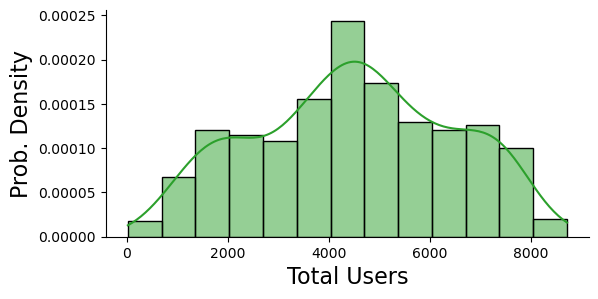

In [272]:
sns.displot(df_train['total_users'], kde=True, height=3, aspect=2, stat='density', color='tab:green')
plt.xlabel('Total Users', fontsize=16)
plt.ylabel('Prob. Density', fontsize=16)
plt.show()


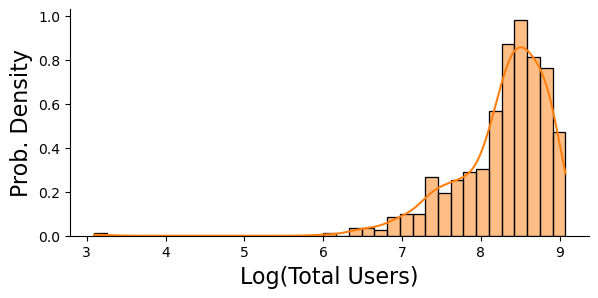

In [273]:
sns.displot(np.log(df_train['total_users']), kde=True, height=3, aspect=2, stat='density', color='tab:orange')
plt.xlabel('Log(Total Users)', fontsize=16)
plt.ylabel('Prob. Density', fontsize=16)
plt.show()

So taking the total_users is better than the log of the total_users because it is slightly more notmally distributed.

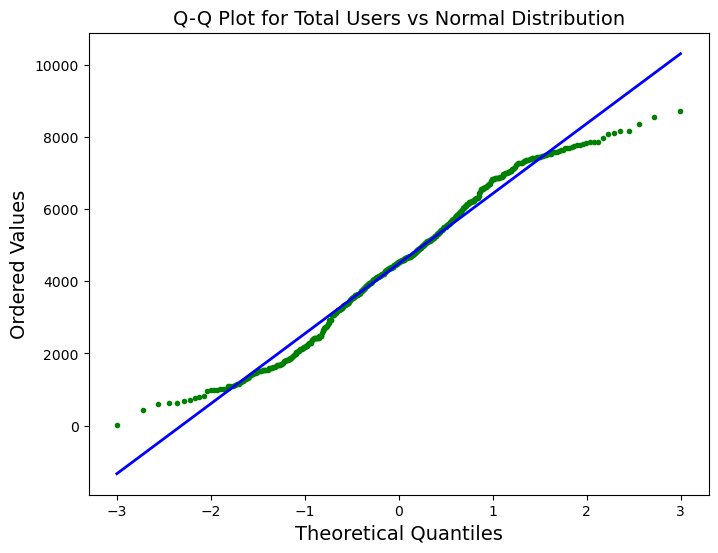

In [274]:
import matplotlib.pyplot as plt
import scipy.stats

fig, ax = plt.subplots(figsize=(8, 6))
scipy.stats.probplot(df_train['total_users'], dist="norm", fit=True, plot=ax)

ax.set_title('Q-Q Plot for Total Users vs Normal Distribution', fontsize=14)
ax.set_xlabel('Theoretical Quantiles', fontsize=14)
ax.set_ylabel('Ordered Values', fontsize=14)
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_markeredgecolor('g')
ax.get_lines()[1].set_linewidth(2.0)
ax.get_lines()[1].set_color('b')
plt.show()


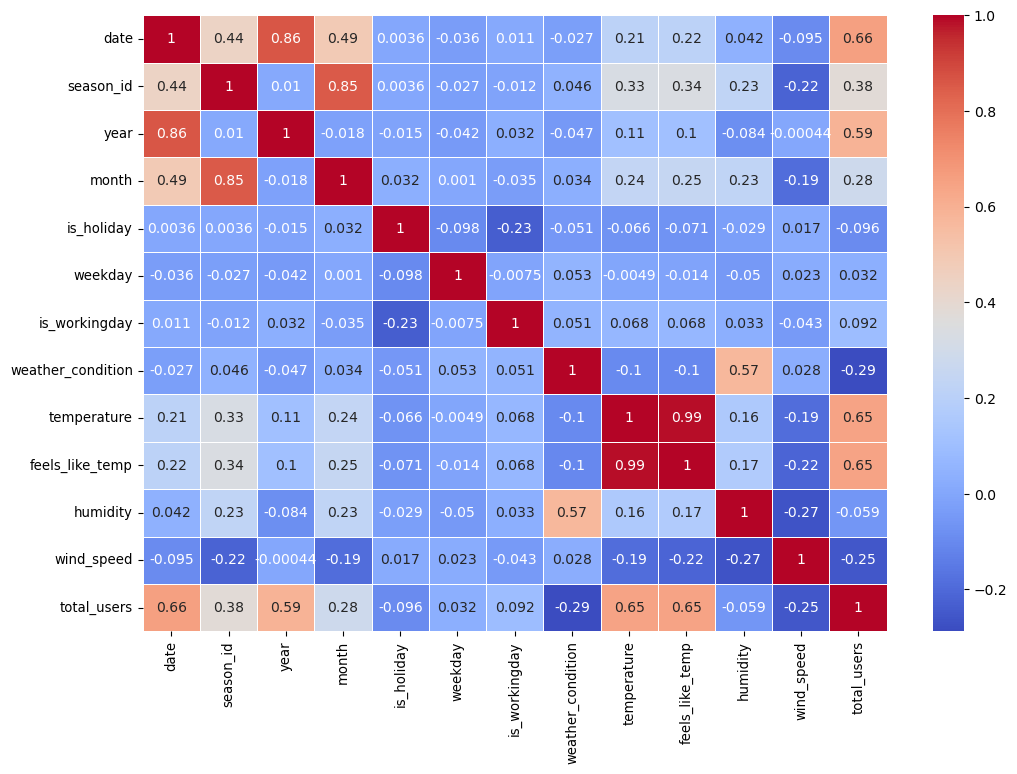

In [275]:
plt.figure(figsize=(12,8))
corr = df_train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)
plt.show()

In [276]:
print(df_train.corr())

                       date  season_id      year     month  is_holiday  \
date               1.000000   0.439663  0.862455  0.488462    0.003633   
season_id          0.439663   1.000000  0.010414  0.851850    0.003607   
year               0.862455   0.010414  1.000000 -0.018313   -0.014980   
month              0.488462   0.851850 -0.018313  1.000000    0.032215   
is_holiday         0.003633   0.003607 -0.014980  0.032215    1.000000   
weekday           -0.035864  -0.026697 -0.041769  0.001042   -0.097993   
is_workingday      0.011335  -0.012226  0.031808 -0.034753   -0.233863   
weather_condition -0.026623   0.045775 -0.047405  0.033648   -0.051163   
temperature        0.214503   0.328975  0.108054  0.240307   -0.066405   
feels_like_temp    0.215472   0.337238  0.104971  0.248223   -0.070760   
humidity           0.042318   0.229128 -0.084061  0.228566   -0.029224   
wind_speed        -0.094997  -0.217737 -0.000439 -0.189047    0.017458   
total_users        0.657712   0.380205

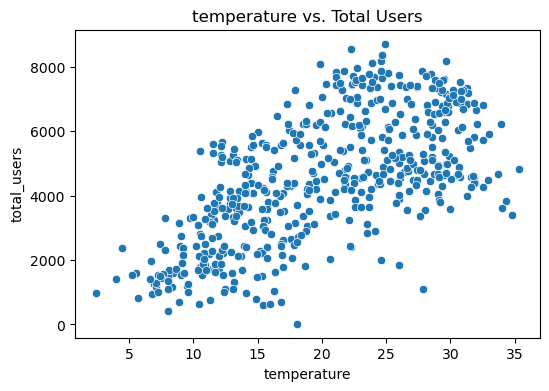

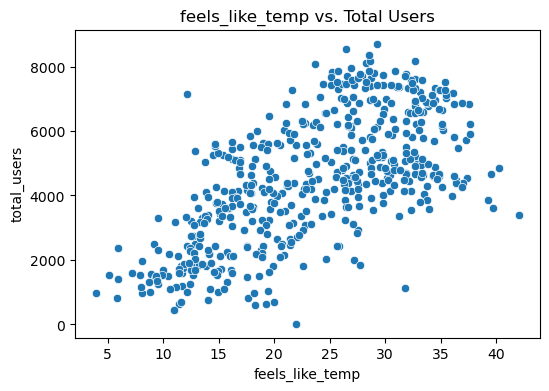

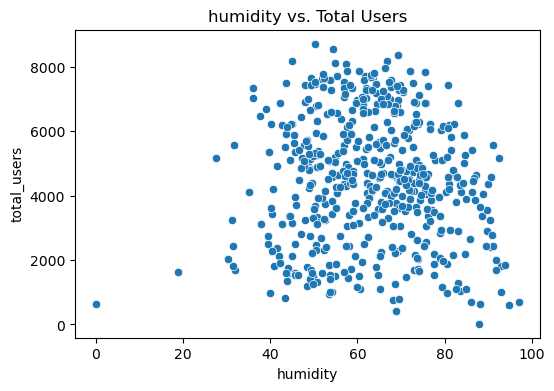

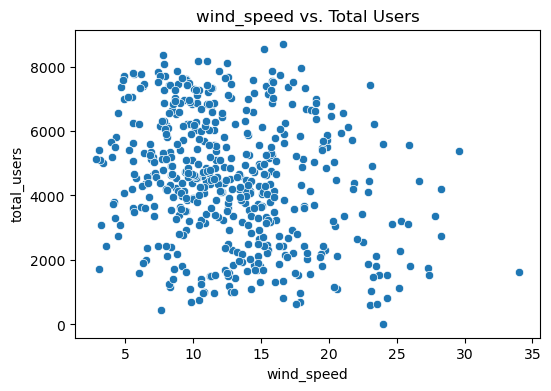

In [277]:
numerical_features = ['temperature', 'feels_like_temp', 'humidity', 'wind_speed']
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_train[feature], y=df_train['total_users'])
    plt.title(f"{feature} vs. Total Users")
    plt.show()

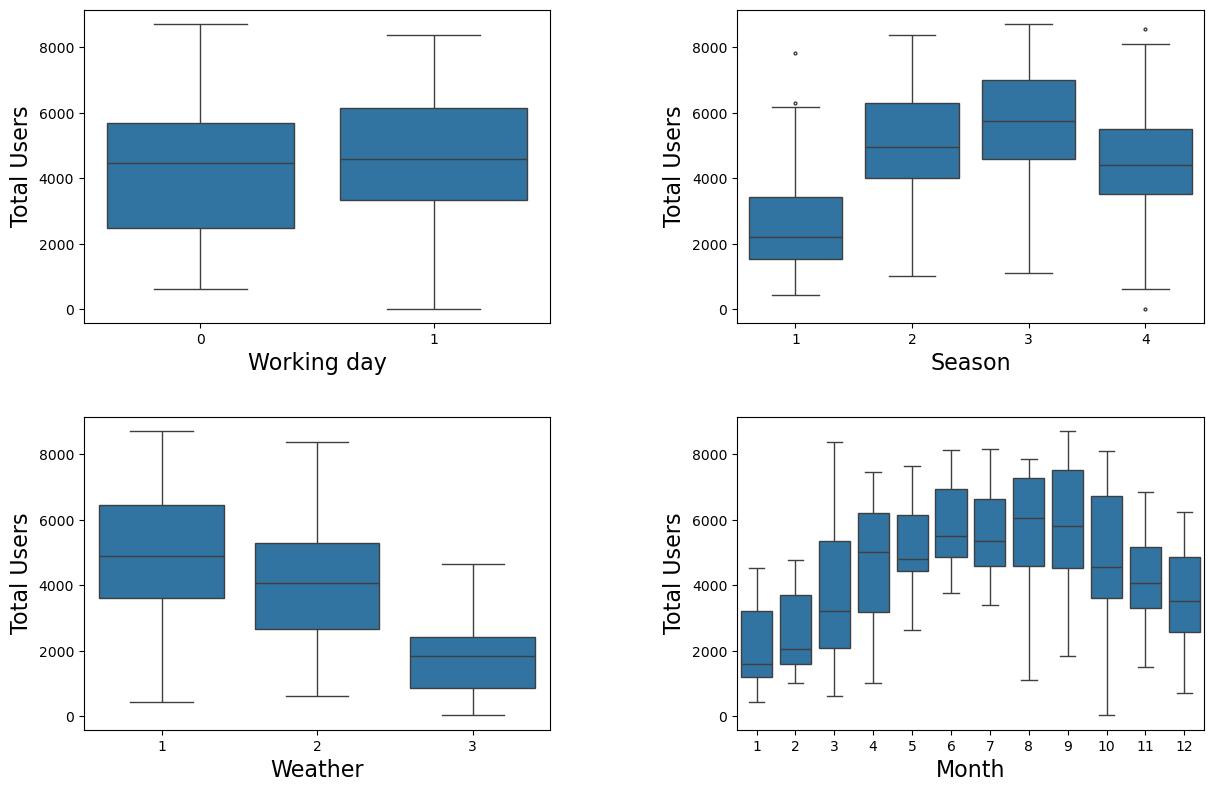

In [278]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(14,9)
sns.boxplot(data=df_train, y="total_users", x="is_workingday", ax=axs[0][0], fliersize=2)
sns.boxplot(data=df_train, y="total_users", x="season_id", ax=axs[0][1], fliersize=2)
sns.boxplot(data=df_train, y="total_users", x="weather_condition", ax=axs[1][0], fliersize=2)
sns.boxplot(data=df_train, y="total_users", x="month", ax=axs[1][1], fliersize=2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)
axs[0][0].set_xlabel('Working day', fontsize=16)
axs[0][0].set_ylabel('Total Users', fontsize=16)
axs[0][1].set_xlabel('Season', fontsize=16)
axs[0][1].set_ylabel('Total Users', fontsize=16)
axs[1][0].set_xlabel('Weather', fontsize=16)
axs[1][0].set_ylabel('Total Users', fontsize=16)
axs[1][1].set_xlabel('Month', fontsize=16)
axs[1][1].set_ylabel('Total Users', fontsize=16)
plt.show()

In [ ]:
def engineer_features(df):
    df['month_sin'] = np.sin((df['month']-1)*(2*np.pi/12))
    df['month_cos'] = np.cos((df['month']-1)*(2*np.pi/12))
    df['weekday_sin'] = np.sin(df['weekday']*(2*np.pi/7))
    df['weekday_cos'] = np.cos(df['weekday']*(2*np.pi/7))
    
    df = pd.get_dummies(df, columns=['weather_condition'], prefix='weather', drop_first=True)

    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    df['temp_squared'] = df['temperature'] ** 2
    special_dates = ['01-01-2018', '25-12-2018', '01-01-2019', '25-12-2019']
    df['is_special_event'] = df['date'].isin(special_dates).astype(int)
    df['temp_weather_2'] = df['temperature'] * df['weather_2']
    df['temp_weather_3'] = df['temperature'] * df['weather_3']


    df= df.drop(['date'],axis=1)
    # Interaction features
    # df['temp_weekend'] = df['temperature'] * (df['weekday'] >= 5).astype(int)
    
    # Drop original date
    return df

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

df_train.head()



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22924\1529097349.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_special_event'] = df['date'].isin(special_dates).astype(int)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22924\1529097349.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_special_event'] = df['date'].isin(special_dates).astype(int)


season_id  year  month  is_holiday  weekday  is_workingday  temperature  \
0          3     1      7           0        2              1    29.246653   
1          1     1      3           0        6              0    16.980847   
2          1     1     12           0        0              0    10.489153   
3          2     1      4           0        6              0    15.443347   
4          2     0      4           0        5              1    13.803347   

   feels_like_temp  humidity  wind_speed  ...  weekday_sin  weekday_cos  \
0          33.1448   70.4167   11.083475  ...     0.974928    -0.222521   
1          20.6746   62.1250   10.792293  ...    -0.781831     0.623490   
2          11.5850   48.3333   23.500518  ...     0.000000     1.000000   
3          18.8752   48.9583    8.708325  ...    -0.781831     0.623490   
4          16.0977   72.9583   14.707907  ...    -0.974928    -0.222521   

   weather_2  weather_3  is_weekend  temp_squared  is_special_event  \
0      False      False           0    855.366712                 0   
1       True      False           1    288.349165                 0   
2      False      False           0    110.022331                 0   
3       True      False           1    238.496967                 0   
4       True      False           1    190.532388                 0   

   temp_weather_2  temp_weather_3  temp_weekend  
0        0.000000             0.0      0.000000  
1       16.980847             0.0     16.980847  
2        0.000000             0.0      0.000000  
3       15.443347             0.0     15.443347  
4       13.803347             0.0     13.803347  

[5 rows x 23 columns]

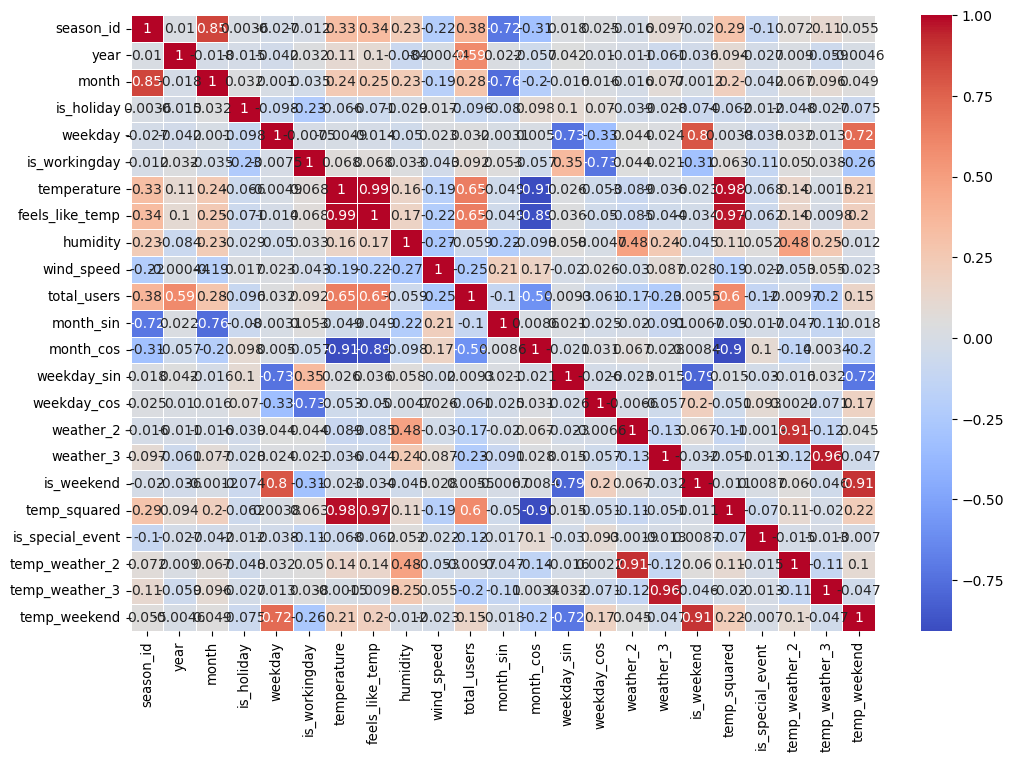

In [284]:
plt.figure(figsize=(12,8))
corr = df_train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)
plt.show()

In [285]:
# df_train = df_train.drop(['feels_like_temp','month', 'weekday'],axis =1)
# df_test = df_test.drop(['feels_like_temp','month', 'weekday'], axis = 1)
# df_train = df_train.drop(['feels_like_temp'],axis =1)
# df_test = df_test.drop(['feels_like_temp'], axis = 1)

In [286]:
df_train['season_cycle'] = (df_train['year'] - df_train['year'].min()) * 4 + df_train['season_id']
df_test['season_cycle'] = (df_test['year'] - df_test['year'].min()) * 4 + df_test['season_id']

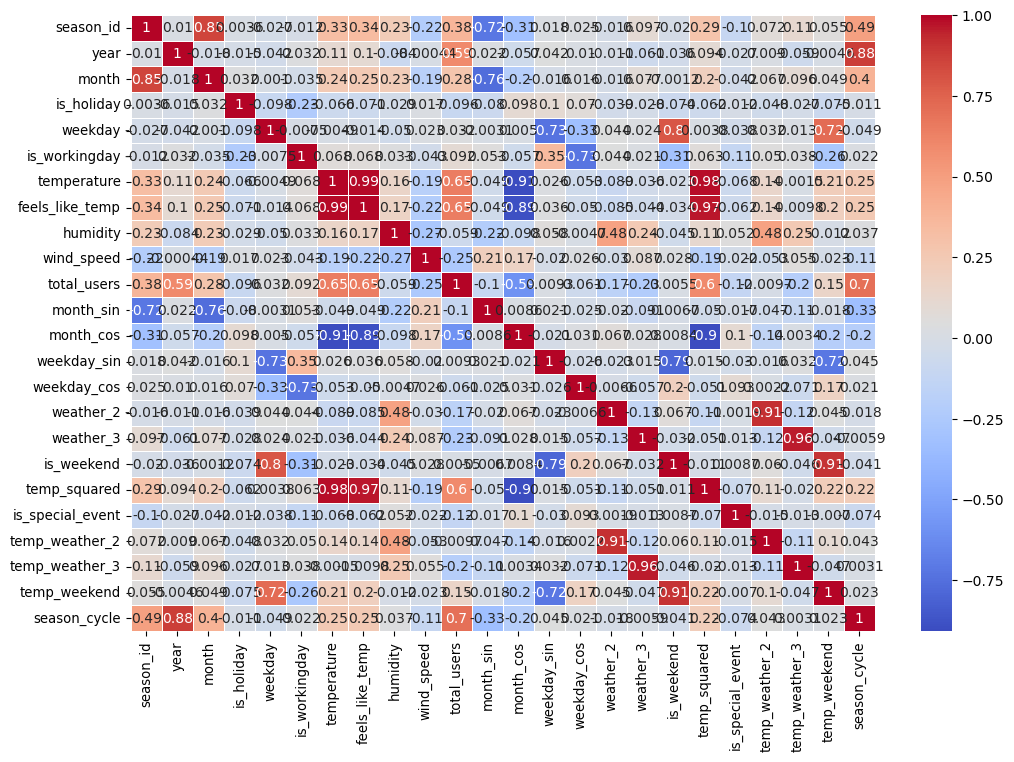

In [287]:
plt.figure(figsize=(12,8))
corr = df_train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)
plt.show()


In [288]:
# df_train['temp_humidity'] = df_train['temperature'] * df_train['humidity']
# plt.figure(figsize=(8,5))
# sns.scatterplot(x=df_train['temp_humidity'], y=df_train['total_users'])
# plt.title("temp_humidity vs Bike Rentals")
# plt.show()

In [289]:
# plt.figure(figsize=(12,8))
# corr = df_train.corr()
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
# plt.xticks(fontsize=9.5)
# plt.yticks(fontsize=9.5)
# plt.show()

In [290]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train = df_train.drop(['total_users'], axis=1)
y = df_train['total_users']

X_test = df_test.drop(['id'],axis=1)

scaler = StandardScaler()
X_scaled_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_scaled_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)



In [291]:
vif = pd.DataFrame()
vif['Features'] = X_scaled_train.columns
vif['VIF'] = [variance_inflation_factor(X_scaled_train.values, i) for i in range(X_scaled_train.shape[1])]
vif['VIF'] = vif['VIF'].round(2)
vif = vif.sort_values(by='VIF', ascending=False)
print(vif)

            Features     VIF
0          season_id     inf
1               year     inf
22      season_cycle     inf
6        temperature  132.51
7    feels_like_temp   56.17
17      temp_squared   48.19
16        is_weekend   18.95
15         weather_3   14.31
20    temp_weather_3   14.08
4            weekday   11.09
14         weather_2    9.74
19    temp_weather_2    9.30
13       weekday_cos    8.49
21      temp_weekend    8.39
11         month_cos    6.52
2              month    4.81
5      is_workingday    4.29
12       weekday_sin    3.97
10         month_sin    3.36
8           humidity    1.99
9         wind_speed    1.27
3         is_holiday    1.25
18  is_special_event    1.07


c:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [292]:
# X_scaled_train = X_scaled_train.drop(['year'], axis = 1)
# X_scaled_test = X_scaled_test.drop(['year'], axis =1)

In [293]:
vif = pd.DataFrame()
vif['Features'] = X_scaled_train.columns
vif['VIF'] = [variance_inflation_factor(X_scaled_train.values, i) for i in range(X_scaled_train.shape[1])]
vif['VIF'] = vif['VIF'].round(2)
vif = vif.sort_values(by='VIF', ascending=False)
print(vif)

            Features     VIF
0          season_id     inf
1               year     inf
22      season_cycle     inf
6        temperature  132.51
7    feels_like_temp   56.17
17      temp_squared   48.19
16        is_weekend   18.95
15         weather_3   14.31
20    temp_weather_3   14.08
4            weekday   11.09
14         weather_2    9.74
19    temp_weather_2    9.30
13       weekday_cos    8.49
21      temp_weekend    8.39
11         month_cos    6.52
2              month    4.81
5      is_workingday    4.29
12       weekday_sin    3.97
10         month_sin    3.36
8           humidity    1.99
9         wind_speed    1.27
3         is_holiday    1.25
18  is_special_event    1.07


c:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [294]:
X_scaled_sm = sm.add_constant(X_scaled_train)

ols_model = sm.OLS(y, X_scaled_sm).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            total_users   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     139.8
Date:                Tue, 13 May 2025   Prob (F-statistic):          2.11e-194
Time:                        23:40:45   Log-Likelihood:                -4079.4
No. Observations:                 510   AIC:                             8205.
Df Residuals:                     487   BIC:                             8302.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4485.3373     32.649  

In [295]:
# season_id	0.579
# is_workingday	0.524
# weekday_sin	0.125
# weekday_cos
#X_scaled_train = X_scaled_train.drop(['season_id'],axis=1)
X_scaled_sm = sm.add_constant(X_scaled_train)

ols_model = sm.OLS(y, X_scaled_sm).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            total_users   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     139.8
Date:                Tue, 13 May 2025   Prob (F-statistic):          2.11e-194
Time:                        23:40:46   Log-Likelihood:                -4079.4
No. Observations:                 510   AIC:                             8205.
Df Residuals:                     487   BIC:                             8302.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4485.3373     32.649  

In [296]:
#X_scaled_train = X_scaled_train.drop(['is_workingday'],axis=1)
X_scaled_sm = sm.add_constant(X_scaled_train)

ols_model = sm.OLS(y, X_scaled_sm).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            total_users   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     139.8
Date:                Tue, 13 May 2025   Prob (F-statistic):          2.11e-194
Time:                        23:40:46   Log-Likelihood:                -4079.4
No. Observations:                 510   AIC:                             8205.
Df Residuals:                     487   BIC:                             8302.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4485.3373     32.649  

In [297]:
#X_scaled_train = X_scaled_train.drop(['weekday_sin'],axis=1)
X_scaled_sm = sm.add_constant(X_scaled_train)

ols_model = sm.OLS(y, X_scaled_sm).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            total_users   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     139.8
Date:                Tue, 13 May 2025   Prob (F-statistic):          2.11e-194
Time:                        23:40:47   Log-Likelihood:                -4079.4
No. Observations:                 510   AIC:                             8205.
Df Residuals:                     487   BIC:                             8302.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4485.3373     32.649  

In [298]:
# X_scaled_train = X_scaled_train.drop(['weekday_cos'],axis=1)
# X_scaled_sm = sm.add_constant(X_scaled_train)

# ols_model = sm.OLS(y, X_scaled_sm).fit()

# print(ols_model.summary())


So as the result removing the weekday_cos wasnt beneficial to the model 

In [299]:
# df_train = df_train.drop(columns=['season_id', 'is_workingday', 'weekday_sin'])
# df_test = df_test.drop(columns=['id','season_id', 'is_workingday', 'weekday_sin'])
df_test = df_test.drop(['id'],axis=1)


In [300]:
from sklearn.preprocessing import MinMaxScaler

X = df_train.drop(columns=['total_users'])
y = df_train['total_users']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_test_final = scaler.transform(df_test)


In [229]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, max_depth=5, random_state=42)
}

# Train models, evaluate, and save test predictions
for name, model in models.items():
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    # Evaluation on training data
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"{name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.3f}")
    print("-" * 30)

    # Predict on test data
    test_pred = model.predict(X_test_final)

    # Build dataframe
    result_df = pd.DataFrame({
        "id": range(1, len(test_pred) + 1),
        "label": test_pred
    })

    # Clean file name
    file_safe_name = name.lower().replace(" ", "_") + "_2predictions.csv"

    # Save CSV
    result_df.to_csv(file_safe_name, index=False)


Linear Regression:
  MSE: 521715.86
  MAE: 537.03
  R²: 0.863
------------------------------
Ridge Regression:
  MSE: 617595.20
  MAE: 571.50
  R²: 0.837
------------------------------
Decision Tree:
  MSE: 401230.06
  MAE: 467.00
  R²: 0.894
------------------------------
Random Forest:
  MSE: 84009.75
  MAE: 211.13
  R²: 0.978
------------------------------
Gradient Boosting:
  MSE: 4067.07
  MAE: 49.03
  R²: 0.999
------------------------------


In [230]:
y_pred = ols_model.predict(X_scaled_sm)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"  MSE: {mse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R²: {r2:.3f}")
print("-" * 30)

  MSE: 519884.91
  MAE: 538.24
  R²: 0.863
------------------------------


In [231]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Models (original config)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.3),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
}

# Train on full data, evaluate on same, and save predictions
for name, model in models.items():
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    # Evaluation (training set)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Cross-validation score (optional)
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)

    print(f"{name}:")
    print(f"  MSE (train): {mse:.2f}")
    print(f"  MAE (train): {mae:.2f}")
    print(f"  R² (train): {r2:.3f}")
    print(f"  CV MSE (5-fold): {cv_mse:.2f}")
    print("-" * 40)

    # Predict on test set
    test_pred = model.predict(X_test_final)

    # Save to CSV
    result_df = pd.DataFrame({
        "id": range(1, len(test_pred) + 1),
        "label": test_pred
    })
    file_safe_name = name.lower().replace(" ", "_") + "_4predictions.csv"
    result_df.to_csv(file_safe_name, index=False)


Linear Regression:
  MSE (train): 521715.86
  MAE (train): 537.03
  R² (train): 0.863
  CV MSE (5-fold): 587241.90
----------------------------------------
Ridge Regression:
  MSE (train): 566207.54
  MAE (train): 548.99
  R² (train): 0.851
  CV MSE (5-fold): 651354.77
----------------------------------------
Decision Tree:
  MSE (train): 401230.06
  MAE (train): 467.00
  R² (train): 0.894
  CV MSE (5-fold): 969609.07
----------------------------------------
Random Forest:
  MSE (train): 156100.46
  MAE (train): 299.55
  R² (train): 0.959
  CV MSE (5-fold): 573410.01
----------------------------------------
Gradient Boosting:
  MSE (train): 69193.05
  MAE (train): 198.00
  R² (train): 0.982
  CV MSE (5-fold): 493034.65
----------------------------------------


In [232]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load data
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

train_path = "regression-dataset-train.csv"
test_path = "regression-dataset-test-unlabeled.csv"
df_train, df_test = load_data(train_path, test_path)

# Handle missing values
for col in ['temperature', 'humidity', 'wind_speed']:
    df_train[col].fillna(df_train[col].median(), inplace=True)
    df_test[col].fillna(df_train[col].median(), inplace=True)

# Feature engineering
def engineer_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
    df['month_sin'] = np.sin((df['month'] - 1) * (2 * np.pi / 12))
    df['month_cos'] = np.cos((df['month'] - 1) * (2 * np.pi / 12))
    df['weekday_sin'] = np.sin(df['weekday'] * (2 * np.pi / 7))
    df['weekday_cos'] = np.cos(df['weekday'] * (2 * np.pi / 7))
    df['day_of_month'] = df['date'].dt.day
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    df = pd.get_dummies(df, columns=['weather_condition'], prefix='weather', drop_first=True)
    df['temp_humidity'] = df['temperature'] * df['humidity']
    df['temp_weather_2'] = df['temperature'] * df['weather_2']
    df['temp_weather_3'] = df['temperature'] * df['weather_3']
    df['temp_holiday'] = df['temperature'] * df['is_holiday']
    return df

# Apply feature engineering consistently
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

# Prepare features (drop 'id' and 'date' from both, 'total_users' only from train)
X = df_train.drop(columns=['total_users', 'date', 'id'])
y = df_train['total_users']
X_test = df_test.drop(columns=['date', 'id'])

# Verify column alignment
print("Training features:", X.columns.tolist())
print("Test features:", X_test.columns.tolist())
assert X.columns.tolist() == X_test.columns.tolist(), "Training and test features do not match!"

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)  # Use transform, not fit_transform

# Split for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

# Evaluate models
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    mse_cv = -cv_scores.mean()
    print(f"{name} - Cross-Validated MSE: {mse_cv:.2f} (±{cv_scores.std():.2f})")
    
    # Validation set
    model.fit(X_train_split, y_train_split)
    y_val_pred = model.predict(X_val_split)
    mse = mean_squared_error(y_val_split, y_val_pred)
    mae = mean_absolute_error(y_val_split, y_val_pred)
    r2 = r2_score(y_val_split, y_val_pred)
    mape = np.mean(np.abs((y_val_split - y_val_pred) / y_val_split)) * 100
    print(f"{name} - Validation MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}, MAPE: {mape:.2f}%")
    print("-" * 30)

# Tune Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_scaled, y)
print(f"Best Gradient Boosting parameters: {grid_search.best_params_}")
print(f"Best CV MSE: {-grid_search.best_score_:.2f}")
best_model = grid_search.best_estimator_

# Feature importance
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))

# Generate predictions
test_pred = best_model.predict(X_test_scaled)
result_df = pd.DataFrame({'id': range(1, len(test_pred) + 1), 'label': test_pred})
result_df.to_csv('gradient_boosting_predictions.csv', index=False)

Training features: ['season_id', 'year', 'month', 'is_holiday', 'weekday', 'is_workingday', 'temperature', 'feels_like_temp', 'humidity', 'wind_speed', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'day_of_month', 'is_weekend', 'weather_2', 'weather_3', 'temp_humidity', 'temp_weather_2', 'temp_weather_3', 'temp_holiday']
Test features: ['season_id', 'year', 'month', 'is_holiday', 'weekday', 'is_workingday', 'temperature', 'feels_like_temp', 'humidity', 'wind_speed', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'day_of_month', 'is_weekend', 'weather_2', 'weather_3', 'temp_humidity', 'temp_weather_2', 'temp_weather_3', 'temp_holiday']


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22924\1025023397.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna(df_train[col].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22924\1025023397.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

Linear Regression - Cross-Validated MSE: 793310.57 (±88553.80)
Linear Regression - Validation MSE: 808274.05, MAE: 653.41, R²: 0.738, MAPE: 21.28%
------------------------------
Ridge Regression - Cross-Validated MSE: 770875.04 (±96640.90)
Ridge Regression - Validation MSE: 807537.20, MAE: 652.30, R²: 0.738, MAPE: 21.24%
------------------------------
Decision Tree - Cross-Validated MSE: 1098004.78 (±318884.82)
Decision Tree - Validation MSE: 872528.17, MAE: 665.38, R²: 0.717, MAPE: 21.35%
------------------------------
Random Forest - Cross-Validated MSE: 589469.34 (±125162.90)
Random Forest - Validation MSE: 600833.62, MAE: 542.32, R²: 0.805, MAPE: 18.05%
------------------------------
Gradient Boosting - Cross-Validated MSE: 536470.54 (±114873.61)
Gradient Boosting - Validation MSE: 543104.01, MAE: 505.90, R²: 0.824, MAPE: 16.98%
------------------------------
Best Gradient Boosting parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_

In [233]:
# behtarinnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LinearRegression, Ridge
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.model_selection import train_test_split, cross_val_score
# import optuna

# # Scale features with MinMaxScaler
# scaler = MinMaxScaler()
# X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# X_test_final = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# # Verify column alignment
# assert list(X_scaled.columns) == list(X_test_final.columns), "Training and test feature columns do not match!"

# # Split training data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X_scaled, y, test_size=0.2, random_state=42
# )

# # Define Optuna objective functions for each model
# def objective_ridge(trial):
#     alpha = trial.suggest_float('alpha', 0.01, 10.0, log=True)
#     model = Ridge(alpha=alpha, random_state=42)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     return mean_squared_error(y_val, y_pred)

# def objective_decision_tree(trial):
#     max_depth = trial.suggest_int('max_depth', 3, 15)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     model = DecisionTreeRegressor(
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     return mean_squared_error(y_val, y_pred)

# def objective_random_forest(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     max_depth = trial.suggest_int('max_depth', 5, 20)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     return mean_squared_error(y_val, y_pred)

# def objective_gradient_boosting(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     model = GradientBoostingRegressor(
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     return mean_squared_error(y_val, y_pred)

# # Run Optuna optimization
# n_trials = 50  # Number of trials for each model
# best_params = {}

# # Linear Regression (no tuning)
# best_params["Linear Regression"] = {}  # Default parameters

# # Ridge Regression
# study_ridge = optuna.create_study(direction='minimize')
# study_ridge.optimize(objective_ridge, n_trials=n_trials)
# best_params["Ridge Regression"] = study_ridge.best_params

# # Decision Tree
# study_dt = optuna.create_study(direction='minimize')
# study_dt.optimize(objective_decision_tree, n_trials=n_trials)
# best_params["Decision Tree"] = study_dt.best_params

# # Random Forest
# study_rf = optuna.create_study(direction='minimize')
# study_rf.optimize(objective_random_forest, n_trials=n_trials)
# best_params["Random Forest"] = study_rf.best_params

# # Gradient Boosting
# study_gb = optuna.create_study(direction='minimize')
# study_gb.optimize(objective_gradient_boosting, n_trials=n_trials)
# best_params["Gradient Boosting"] = study_gb.best_params

# # Print best parameters
# for model_name, params in best_params.items():
#     print(f"Best parameters for {model_name}: {params}")

# # Define models with best parameters
# models = {
#     "Linear Regression": LinearRegression(),
#     "Ridge Regression": Ridge(alpha=best_params["Ridge Regression"]['alpha'], random_state=42),
#     "Decision Tree": DecisionTreeRegressor(
#         max_depth=best_params["Decision Tree"]['max_depth'],
#         min_samples_split=best_params["Decision Tree"]['min_samples_split'],
#         min_samples_leaf=best_params["Decision Tree"]['min_samples_leaf'],
#         random_state=42
#     ),
#     "Random Forest": RandomForestRegressor(
#         n_estimators=best_params["Random Forest"]['n_estimators'],
#         max_depth=best_params["Random Forest"]['max_depth'],
#         min_samples_split=best_params["Random Forest"]['min_samples_split'],
#         min_samples_leaf=best_params["Random Forest"]['min_samples_leaf'],
#         random_state=42
#     ),
#     "Gradient Boosting": GradientBoostingRegressor(
#         n_estimators=best_params["Gradient Boosting"]['n_estimators'],
#         learning_rate=best_params["Gradient Boosting"]['learning_rate'],
#         max_depth=best_params["Gradient Boosting"]['max_depth'],
#         min_samples_split=best_params["Gradient Boosting"]['min_samples_split'],
#         min_samples_leaf=best_params["Gradient Boosting"]['min_samples_leaf'],
#         random_state=42
#     )
# }

# # Train on full data, evaluate on same, and save predictions
# for name, model in models.items():
#     model.fit(X_scaled, y)
#     y_pred = model.predict(X_scaled)

#     # Evaluation (training set)
#     mse = mean_squared_error(y, y_pred)
#     mae = mean_absolute_error(y, y_pred)
#     r2 = r2_score(y, y_pred)

#     # Cross-validation score
#     cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
#     cv_mse = -np.mean(cv_scores)

#     print(f"{name}:")
#     print(f"  MSE (train): {mse:.2f}")
#     print(f"  MAE (train): {mae:.2f}")
#     print(f"  R² (train): {r2:.3f}")
#     print(f"  CV MSE (5-fold): {cv_mse:.2f}")
#     print("-" * 40)

#     # Predict on test set
#     test_pred = model.predict(X_test_final)

#     # Save to CSV
#     result_df = pd.DataFrame({
#         "id": range(1, len(test_pred) + 1),
#         "label": test_pred
#     })
#     file_safe_name = name.lower().replace(" ", "_") + "_4predictions.csv"
#     result_df.to_csv(file_safe_name, index=False)

In [234]:
!pip install optuna

In [235]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import optuna

# Scale features with MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_test_final = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Verify column alignment
assert list(X_scaled.columns) == list(X_test_final.columns), "Training and test feature columns do not match!"

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Define Optuna objective functions for each model
def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 0.01, 10.0, log=True)
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_decision_tree(trial):
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_gradient_boosting(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

# Run Optuna optimization
n_trials = 100  # Number of trials for each model
best_params = {}

# Linear Regression (no tuning)
best_params["Linear Regression"] = {}  # Default parameters

# Ridge Regression
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=n_trials)
best_params["Ridge Regression"] = study_ridge.best_params

# Decision Tree
study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_decision_tree, n_trials=n_trials)
best_params["Decision Tree"] = study_dt.best_params

# Random Forest
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_random_forest, n_trials=n_trials)
best_params["Random Forest"] = study_rf.best_params

# Gradient Boosting
study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gradient_boosting, n_trials=n_trials)
best_params["Gradient Boosting"] = study_gb.best_params

# Print best parameters
for model_name, params in best_params.items():
    print(f"Best parameters for {model_name}: {params}")

# Define models with best parameters
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=best_params["Ridge Regression"]['alpha'], random_state=42),
    "Decision Tree": DecisionTreeRegressor(
        max_depth=best_params["Decision Tree"]['max_depth'],
        min_samples_split=best_params["Decision Tree"]['min_samples_split'],
        min_samples_leaf=best_params["Decision Tree"]['min_samples_leaf'],
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=best_params["Random Forest"]['n_estimators'],
        max_depth=best_params["Random Forest"]['max_depth'],
        min_samples_split=best_params["Random Forest"]['min_samples_split'],
        min_samples_leaf=best_params["Random Forest"]['min_samples_leaf'],
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=best_params["Gradient Boosting"]['n_estimators'],
        learning_rate=best_params["Gradient Boosting"]['learning_rate'],
        max_depth=best_params["Gradient Boosting"]['max_depth'],
        min_samples_split=best_params["Gradient Boosting"]['min_samples_split'],
        min_samples_leaf=best_params["Gradient Boosting"]['min_samples_leaf'],
        random_state=42
    )
}

# Train on full data, evaluate on same, and save predictions
for name, model in models.items():
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    # Evaluation (training set)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)

    print(f"{name}:")
    print(f"  MSE (train): {mse:.2f}")
    print(f"  MAE (train): {mae:.2f}")
    print(f"  R² (train): {r2:.3f}")
    print(f"  CV MSE (5-fold): {cv_mse:.2f}")
    print("-" * 40)

    # Predict on test set
    test_pred = model.predict(X_test_final)

    # Save to CSV
    result_df = pd.DataFrame({
        "id": range(1, len(test_pred) + 1),
        "label": test_pred
    })
    file_safe_name = name.lower().replace(" ", "_") + "_4predictions.csv"
    result_df.to_csv(file_safe_name, index=False)

[I 2025-05-13 19:48:00,630] A new study created in memory with name: no-name-d9af6e79-ec8d-4ceb-ad1e-3951d5fcc071
[I 2025-05-13 19:48:00,649] Trial 0 finished with value: 793735.4872268473 and parameters: {'alpha': 0.6577064129009766}. Best is trial 0 with value: 793735.4872268473.
[I 2025-05-13 19:48:00,667] Trial 1 finished with value: 804005.5157193607 and parameters: {'alpha': 0.0897737872542341}. Best is trial 0 with value: 793735.4872268473.
[I 2025-05-13 19:48:00,686] Trial 2 finished with value: 791317.1405943296 and parameters: {'alpha': 0.965680934750289}. Best is trial 2 with value: 791317.1405943296.
[I 2025-05-13 19:48:00,707] Trial 3 finished with value: 803727.6904994627 and parameters: {'alpha': 8.685931391826223}. Best is trial 2 with value: 791317.1405943296.
[I 2025-05-13 19:48:00,737] Trial 4 finished with value: 806930.9532516248 and parameters: {'alpha': 0.023680652302828606}. Best is trial 2 with value: 791317.1405943296.
[I 2025-05-13 19:48:00,762] Trial 5 finis

Best parameters for Linear Regression: {}
Best parameters for Ridge Regression: {'alpha': 2.8298015363497155}
Best parameters for Decision Tree: {'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 3}
Best parameters for Random Forest: {'n_estimators': 278, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best parameters for Gradient Boosting: {'n_estimators': 161, 'learning_rate': 0.06390137634865269, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 1}
Linear Regression:
  MSE (train): 675222.26
  MAE (train): 601.51
  R² (train): 0.822
  CV MSE (5-fold): 793310.57
----------------------------------------
Ridge Regression:
  MSE (train): 684839.76
  MAE (train): 604.24
  R² (train): 0.820
  CV MSE (5-fold): 749047.24
----------------------------------------
Decision Tree:
  MSE (train): 279697.07
  MAE (train): 363.61
  R² (train): 0.926
  CV MSE (5-fold): 891446.53
----------------------------------------
Random Forest:
  MSE (train): 75666.41
  M

In [302]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor
import optuna

# Scale features with MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_test_final = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Verify column alignment
assert list(X_scaled.columns) == list(X_test_final.columns), "Training and test feature columns do not match!"

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Define Optuna objective functions with expanded search space
def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 0.001, 100.0, log=True)
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_decision_tree(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_gradient_boosting(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.5, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def objective_catboost(trial):
    iterations = trial.suggest_int('iterations', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.5, log=True)
    depth = trial.suggest_int('depth', 3, 12)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        random_state=42,
        verbose=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

# Run Optuna optimization
n_trials = 80  # Number of trials for each model
best_params = {}

# Linear Regression (no tuning)
best_params["Linear Regression"] = {}  # Default parameters

# Ridge Regression
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=n_trials)
best_params["Ridge Regression"] = study_ridge.best_params

# Decision Tree
study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_decision_tree, n_trials=n_trials)
best_params["Decision Tree"] = study_dt.best_params

# Random Forest
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_random_forest, n_trials=n_trials)
best_params["Random Forest"] = study_rf.best_params

# Gradient Boosting
study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gradient_boosting, n_trials=n_trials)
best_params["Gradient Boosting"] = study_gb.best_params

# CatBoost
study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective_catboost, n_trials=n_trials)
best_params["CatBoost"] = study_cb.best_params

# Print best parameters
for model_name, params in best_params.items():
    print(f"Best parameters for {model_name}: {params}")

# Define base models with best parameters
base_models = [
    ('rf', RandomForestRegressor(
        n_estimators=best_params["Random Forest"]['n_estimators'],
        max_depth=best_params["Random Forest"]['max_depth'],
        min_samples_split=best_params["Random Forest"]['min_samples_split'],
        min_samples_leaf=best_params["Random Forest"]['min_samples_leaf'],
        max_features=best_params["Random Forest"]['max_features'],
        random_state=42
    )),
    ('gb', GradientBoostingRegressor(
        n_estimators=best_params["Gradient Boosting"]['n_estimators'],
        learning_rate=best_params["Gradient Boosting"]['learning_rate'],
        max_depth=best_params["Gradient Boosting"]['max_depth'],
        min_samples_split=best_params["Gradient Boosting"]['min_samples_split'],
        min_samples_leaf=best_params["Gradient Boosting"]['min_samples_leaf'],
        subsample=best_params["Gradient Boosting"]['subsample'],
        random_state=42
    ))
]

# Define stacking ensemble
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv=5
)

# Define all models with best parameters
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=best_params["Ridge Regression"]['alpha'], random_state=42),
    "Decision Tree": DecisionTreeRegressor(
        max_depth=best_params["Decision Tree"]['max_depth'],
        min_samples_split=best_params["Decision Tree"]['min_samples_split'],
        min_samples_leaf=best_params["Decision Tree"]['min_samples_leaf'],
        random_state=42
    ),
    "Random Forest": base_models[0][1],
    "Gradient Boosting": base_models[1][1],
    "CatBoost": CatBoostRegressor(
        iterations=best_params["CatBoost"]['iterations'],
        learning_rate=best_params["CatBoost"]['learning_rate'],
        depth=best_params["CatBoost"]['depth'],
        l2_leaf_reg=best_params["CatBoost"]['l2_leaf_reg'],
        random_state=42,
        verbose=0
    ),
    "Stacking Ensemble": stacking_model
}

# Train on full data, evaluate on train and validation, and save predictions
for name, model in models.items():
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    # Evaluation (training set)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)

    # Validation set evaluation
    y_val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)

    print(f"{name}:")
    print(f"  MSE (train): {mse:.2f}")
    print(f"  MAE (train): {mae:.2f}")
    print(f"  R² (train): {r2:.3f}")
    print(f"  CV MSE (5-fold): {cv_mse:.2f}")
    print(f"  MSE (validation): {val_mse:.2f}")
    print("-" * 40)

    # Predict on test set
    test_pred = model.predict(X_test_final)

    # Save to CSV
    result_df = pd.DataFrame({
        "id": range(1, len(test_pred) + 1),
        "label": test_pred
    })
    file_safe_name = name.lower().replace(" ", "_") + "_4predictions.csv"
    result_df.to_csv(file_safe_name, index=False)

[I 2025-05-13 23:55:25,204] A new study created in memory with name: no-name-50da8a77-ec4f-4cce-b43a-7fc8308af4b3
[I 2025-05-13 23:55:25,278] Trial 0 finished with value: 666057.3544432865 and parameters: {'alpha': 0.3976832826765626}. Best is trial 0 with value: 666057.3544432865.
[I 2025-05-13 23:55:25,289] Trial 1 finished with value: 610890.1239942721 and parameters: {'alpha': 0.12105456754701246}. Best is trial 1 with value: 610890.1239942721.
[I 2025-05-13 23:55:25,299] Trial 2 finished with value: 750725.3310267456 and parameters: {'alpha': 2.1606242330228347}. Best is trial 1 with value: 610890.1239942721.
[I 2025-05-13 23:55:25,307] Trial 3 finished with value: 609425.7873758175 and parameters: {'alpha': 0.11596724315703892}. Best is trial 3 with value: 609425.7873758175.
[I 2025-05-13 23:55:25,320] Trial 4 finished with value: 1163578.4528492207 and parameters: {'alpha': 98.72083462629061}. Best is trial 3 with value: 609425.7873758175.
[I 2025-05-13 23:55:25,327] Trial 5 fin

Best parameters for Linear Regression: {}
Best parameters for Ridge Regression: {'alpha': 0.0010001007866022244}
Best parameters for Decision Tree: {'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 4}
Best parameters for Random Forest: {'n_estimators': 441, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}
Best parameters for Gradient Boosting: {'n_estimators': 136, 'learning_rate': 0.0505679905345387, 'max_depth': 3, 'min_samples_split': 26, 'min_samples_leaf': 2, 'subsample': 0.7495092167134491}
Best parameters for CatBoost: {'iterations': 86, 'learning_rate': 0.15864204890378372, 'depth': 3, 'l2_leaf_reg': 9.151787702448637}
Linear Regression:
  MSE (train): 519130.40
  MAE (train): 536.36
  R² (train): 0.863
  CV MSE (5-fold): 588438.37
  MSE (validation): 508406.78
----------------------------------------
Ridge Regression:
  MSE (train): 519134.86
  MAE (train): 536.21
  R² (train): 0.863
  CV MSE (5-fold): 588515.09
  MSE (validati